In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from scipy.stats import ks_2samp
from scipy.special import binom

from matplotlib import pyplot as plt
%matplotlib inline

inputFolder='../data/'
trainFolder=inputFolder+'train/'
testFolder=inputFolder+'test/'



In [75]:
def readFiles(type='train'):
    if type not in ('train', 'test'):
        print 'error: type must be either \'train\' or \'test\''
        return
    
    folder=trainFolder if type=='train' else testFolder
    
    usersFile=folder+'user_info_'+type+'.txt'
    banksFile=folder+'bank_detail_'+type+'.txt'
    browseFile=folder+'browse_history_'+type+'.txt'
    billsFile=folder+'bill_detail_'+type+'.txt'
    loanTimeFile=folder+'loan_time_'+type+'.txt'
    overdueFile=folder+'overdue_'+type+'.txt'

    users=pd.read_csv(usersFile, \
              names=['id','sex','profession','education','marriage','citizen_type'],\
              index_col=0).sort_index()
    banks=pd.read_csv(banksFile,\
              names=['user_id', 'time', 'transaction_type', 'amount', 'is_salary'])

    browse=pd.read_csv(browseFile,\
               names=['user_id', 'time', 'browse_type', 'sub_type'])
    bills=pd.read_csv(billsFile,\
              names=['user_id', 'time', 'bank_id', 'last_bill_amount', 'last_bill_pay', 'credit_line',\
                     'cur_bill_balance', 'cur_bill_min_due', 'transactionNum', 'cur_bill_amount', \
                     'adjusted_amount', 'cumulative_interest', 'available_deposit', 'available_credit', 'debt_status'])

    loanTimes=pd.read_csv(loanTimeFile,\
              names=['user_id', 'time'], index_col=0).sort_index()

    overdues=pd.read_csv(overdueFile,\
              names=['user_id', 'label'], index_col=0).sort_index().values.ravel() if type=='train' else None
    
    def processTime(time):
        t=time-5746916127
        hour=(t.div(3600)).astype(int)%24
        day=(t.div(3600.0*24)).astype(int)
      
        year=(day.div(365)).astype(int)
        month=(day-365*year).div(30).astype(int)
        weekday=day%7
        monthday=day-year*365-month*30
        
        
        
        
        return year+1, month+1, monthday+1, weekday+1, hour+1
    
    def processTimeInData(d, time='time'):
        year, month, monthday, weekday, hour = processTime(d[time])
        d['year']=year
        d['month']=month
        d['monthday']=monthday
        d['weekday']=weekday
        d['hour']=hour
        return d
    
    banks=processTimeInData(banks)
    bills=processTimeInData(bills)
    browse=processTimeInData(browse)
    
    return users, banks, browse, bills, loanTimes, overdues

# testUsers, testBanks, testBrowse, testBills, testLoanTime, _=readFiles(type='test')

In [76]:
trainUsers, trainBanks, trainBrowse, trainBills, trainLoanTime, trainOverdue=readFiles(type='train')

In [24]:
trainBanks.year.head()

0    5
1    5
2    5
3    5
4    5
Name: year, dtype: int64

In [113]:
trainBrowse['year'].unique()

array([6, 5, 4, 3, 2])

user_id        0
time           0
browse_type    0
sub_type       0
year           0
month          0
monthday       0
weekday        0
hour           0
dtype: int64
user_id                427447
time                   427447
bank_id                427447
last_bill_amount       427447
last_bill_pay          427447
credit_line            427447
cur_bill_balance       427447
cur_bill_min_due       427447
transactionNum         427447
cur_bill_amount        427447
adjusted_amount        427447
cumulative_interest    427447
available_deposit      427447
available_credit       427447
debt_status            427447
year                   427447
month                  427447
monthday               427447
weekday                427447
hour                   427447
dtype: int64
user_id             38773
time                38773
transaction_type    38773
amount              38773
is_salary           38773
year                38773
month               38773
monthday            38773
weekday      

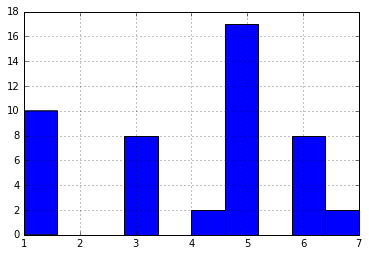

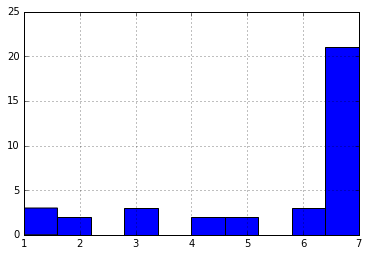

In [110]:
trainBanks[(trainBanks['time']>=0) & (trainBanks['user_id']==26)].weekday.hist()
plt.figure()
trainBills[(trainBills['time']>=0) & (trainBills['user_id']==26)].weekday.hist()
plt.figure()
print trainBrowse[(trainBrowse['time']==0)].count()
print trainBills[(trainBills['time']==0)].count()

print trainBanks[(trainBanks['time']==0)].count()




In [8]:
# # process transaction amounts by converting back to real sum of money.  Have to guess the function

# trialTrainBanks=trainBanks.copy()
# fundConv=lambda x: 2*np.power((np.exp(x)-1),0.5)
# trialTrainBanks['amount']=fundConv(trialTrainBanks['amount'])
# print trialTrainBanks['amount'].head()

In [55]:
def extractBillFeatures(bills, n_ids):
    # prepare a list of banks in the bills form
    
    bank_ids=bills['bank_id'].unique()
    bankBills=dict() # keys are banks ids, and values are bills associated with that bank id.
    for b_id in bank_ids:
        bs=bills[bills.bank_id==b_id]
        if len(bs)>=1:
            bankBills[b_id]=bs
            
    # prepare bank-wise bill features
    billFeatures=pd.DataFrame(np.arange(n_ids)+1, columns=['id'])
    billFeatures.set_index(['id'], inplace=True)
    for b_id in bankBills.keys():
        bankBillName='bank'+str(b_id).zfill(6)
        billFeatures[bankBillName+'AvgCreditLine']=bankBills[b_id].groupby('user_id')['credit_line'].mean()
    #     billFeatures[bankBillName+'MaxCreditLine']=bankBills[b_id].groupby('user_id')['available_credit'].mean()
    billFeatures.fillna(-1, inplace=True)
    
    return billFeatures



In [56]:
# def extractAfterLoanBillFeatures(bills, loanTimes, index):
#     # prepare a list of banks in the bills form
    
#     bank_ids=bills['bank_id'].unique()
#     billsAfter=bills[bills['time']>loanTimes.loc[bills['user_id'], 'time']]
    
#     bankBills=dict() # keys are banks ids, and values are bills associated with that bank id.
#     for b_id in bank_ids:
#         bs=billsAfter[billsAfter.bank_id==b_id]
#         if len(bs)>=1:
#             bankBills[b_id]=bs
            
#     # prepare bank-wise bill features
#     billFeatures=pd.DataFrame(index, columns=['id'])
#     billFeatures.set_index(['id'], inplace=True)
#     for b_id in bankBills.keys():
#         bankBillName='AfterLoanBank'+str(b_id).zfill(6)
#         billFeatures[bankBillName+'AvgCreditLine']=bankBills[b_id].groupby('user_id')['credit_line'].mean()
#     #     billFeatures[bankBillName+'MaxCreditLine']=bankBills[b_id].groupby('user_id')['available_credit'].mean()
#     billFeatures.fillna(-1, inplace=True)
    
#     return billFeatures

# # extractAfterLoanBillFeatures(trainBills, trainLoanTime, trainUsers.index)

In [57]:
def extractBrowseTypeFeatures(browse, n_ids):
    # prepare browseType wise features:

    browseType_ids=browse['browse_type'].unique()
    browseTypes=dict()
    for b_id in browseType_ids:
        bs=browse[browse.browse_type==b_id]
        if len(bs)>=1:
            browseTypes[b_id]=bs

    browseTypeFeatures=pd.DataFrame(np.arange(n_ids)+1, columns=['id'])
    browseTypeFeatures.set_index(['id'], inplace=True)
    for b_id in browseTypes.keys():
        browseTypeName='browseType'+str(b_id).zfill(7)
    #     browseTypeFeatures[browseTypeName+'TotalTimes']=browseTypes[b_id].groupby('user_id')['time'].count()
        browseTypeFeatures[browseTypeName+'Freq']=browseTypes[b_id].groupby('user_id')['time'].count().div\
        (browseTypes[b_id].groupby('user_id')['time'].max()-browseTypes[b_id].groupby('user_id')['time'].min()+1+0.000001)
    browseTypeFeatures.fillna(0, inplace=True)

    return browseTypeFeatures


In [58]:
# add manually picked features to the working dataset

def handPickedFeatures(users, banks, browse, bills, loanTimes):

    handPickedFeatures=pd.DataFrame(np.arange(len(users))+1, columns=['id'])
    handPickedFeatures.set_index(['id'], inplace=True)
    
    
        
    

    # bank record features
    bankRecordsPersonal=banks.groupby('user_id')
    handPickedFeatures['transactionNum']=bankRecordsPersonal['amount'].count()
    handPickedFeatures['transactionAmount']=bankRecordsPersonal['amount'].sum()
    handPickedFeatures['transactionNetAmount']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==1]['amount'].sum())-\
            bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==0]['amount'].sum())
    handPickedFeatures['transactionExpense']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==1]['amount'].sum())
    handPickedFeatures['transactionExpenseMax']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==1]['amount'].max())
    handPickedFeatures['transactionExpenseAvg']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==1]['amount'].mean())
    handPickedFeatures['transactionIncome']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==0]['amount'].sum())
    handPickedFeatures['transactionIncomeMax']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==0]['amount'].max())
    handPickedFeatures['transactionIncomeAvg']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==0]['amount'].mean())
    handPickedFeatures['transactionExpenseNum']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==1]['amount'].count())
    handPickedFeatures['transactionIncomeNum']=bankRecordsPersonal.apply(lambda x: x[x['transaction_type']==0]['amount'].count())
    handPickedFeatures['salaryNum']=bankRecordsPersonal['is_salary'].sum()
    handPickedFeatures['salaryTotal']=bankRecordsPersonal.apply(lambda x: x[x['is_salary']==1]['amount'].sum())
    handPickedFeatures['salaryAvg']=bankRecordsPersonal.apply(lambda x: x[x['is_salary']==1]['amount'].mean())
    handPickedFeatures['salaryMax']=bankRecordsPersonal.apply(lambda x: x[x['is_salary']==1]['amount'].max())


    browseRecordsPersonal=browse.groupby('user_id')
    handPickedFeatures['browseNum']=browseRecordsPersonal['time'].count()
    handPickedFeatures['browseFreq']=(browseRecordsPersonal['time'].count()).div(browseRecordsPersonal['time'].max()-browseRecordsPersonal['time'].min()+1+0.000001)
    handPickedFeatures['browseTypes']=browseRecordsPersonal['browse_type'].nunique()
    handPickedFeatures['browseSubTypes']=browseRecordsPersonal.apply(lambda x: x.groupby('browse_type')['sub_type'].nunique().sum())


    billsPersonal=bills.groupby('user_id')
    handPickedFeatures['billBanksNum']=billsPersonal['bank_id'].nunique()
    handPickedFeatures['billNum']=billsPersonal['time'].count()
    handPickedFeatures['underpay']=billsPersonal.apply(lambda x: 1.0*sum(x['last_bill_amount']-x['last_bill_pay'])/len(x))
    handPickedFeatures['avgCreditLine']=billsPersonal.apply(lambda x: x['credit_line'].mean())

#     handPickedFeatures['avgCreditLine']=billsPersonal.apply(lambda x: x[x['credit_line']>0]['credit_line'].mean())
    handPickedFeatures['avgTransactionNum']=billsPersonal['transactionNum'].mean()
    handPickedFeatures['maxBankCredit_line']=billsPersonal.apply(lambda x: x.groupby('bank_id')['credit_line'].mean().max())
    handPickedFeatures['avgLastBillAmount']=billsPersonal.apply(lambda x: x.groupby('bank_id')['last_bill_amount'].mean().mean())
    handPickedFeatures['avgMaxLastBillAmount']=billsPersonal.apply(lambda x: x.groupby('bank_id')['last_bill_amount'].max().mean())
    handPickedFeatures['relative_bill_adjustment']=(billsPersonal['cur_bill_amount'].mean()-billsPersonal['adjusted_amount'].mean()).div(billsPersonal['cur_bill_amount'].mean()+0.00001)
    
    
    def timeSpan(x):
        return x['time'].max()-x[x['time']>0]['time'].min()
    
#     def totalBankBillTimeSpan(x):
#         newX=x[x['time']>0]
#         byBank=newX.groupby('bank_id')
#         return (byBank['time'].max()-byBank['time'].min()).sum()
        
    handPickedFeatures['avgBillTimeSpan']=billsPersonal.apply(timeSpan)
    handPickedFeatures['maxBankBillTimeSpan']=billsPersonal.apply(lambda x: (x.groupby('bank_id')['time'].max()-x.groupby('bank_id')['time'].min()).max())
    handPickedFeatures['totalBankBillTimeSpan']=billsPersonal.apply(lambda x: (x.groupby('bank_id')['time'].max()-x.groupby('bank_id')['time'].min()).sum())
    handPickedFeatures['debtNum']=billsPersonal['debt_status'].mean()

    
    
    handPickedFeatures['afterLoanBillFreq']=billsPersonal.apply(afterLoanBillFreq)
    handPickedFeatures['afterLoanBillNum']=billsPersonal.apply(lambda x: x[x['time']>trainLoanTime.loc[x['user_id'].mean(),'time']]['time'].count())
    handPickedFeatures['afterLoanUnderpay']=billsPersonal.apply(afterLoanUnderpay)
    handPickedFeatures['afterLoanSalaryChange']=bankRecordsPersonal.apply(afterLoanSalaryChange)
    handPickedFeatures['afterLoanBillTimeSpan']=billsPersonal.apply(lambda x: x['time'].max()-trainLoanTime.loc[x['user_id'].mean(),'time'])
    handPickedFeatures['beforeLoanBillTimeSpan']=billsPersonal.apply(lambda x: trainLoanTime.loc[x['user_id'].mean(),'time']-x['time'].min())
    handPickedFeatures['afterLoanBillAdjustment']=billsPersonal.apply(afterLoanBillAdjustment)
    
    
    

    handPickedFeatures['loanTime']=trainLoanTime['time']

    return handPickedFeatures


In [59]:
# make a working dataset for training and testing
trainUsers, trainBanks, trainBrowse, trainBills, trainLoanTime, trainOverdue=readFiles(type='train')

In [60]:
finalTime=trainBills['time'].max()+1
startTime=trainBills['time'].min()-1
def afterLoanBillFreq(x):
    lt=trainLoanTime.loc[x['user_id'].mean(),'time']
    return float(x[x['time']>lt]['time'].count())/float(finalTime-lt)

# afterLoanBrowseFreq=afterLoanBillFreq

def afterLoanSalaryChange(x):
    lt=trainLoanTime.loc[x['user_id'].mean(),'time']
    beforeSalary=x[(x['is_salary']==1) & (x['time']<=lt)]['amount'].mean()
    afterSalary=x[(x['is_salary']==1) & (x['time']>lt)]['amount'].mean()
#     if np.isnan(afterSalary) and ~np.isnan(beforeSalary):
#         afterSalary=0
#     if np.isnan(beforeSalary) and ~np.isnan(afterSalary):
#         beforeSalary=0
    return afterSalary-beforeSalary

# def afterLoanNetIncome(x):
#     lt=trainLoanTime.loc[x['user_id'].mean(),'time']
#     income=x[(x['transaction_type']==0) & (x['time']>lt)]['amount'].sum()
#     expense=x[(x['transaction_type']==1) & (x['time']>lt)]['amount'].sum()
#     return income-expense

# def afterLoanIncomeChange(x):
#     lt=trainLoanTime.loc[x['user_id'].mean(),'time']
#     beforeIncome=float(x[(x['transaction_type']==0) & (x['time']<=lt)]['amount'].sum())/float(lt-startTime)
#     afterIncome=float(x[(x['transaction_type']==0) & (x['time']>lt)]['amount'].sum())/float(finalTime-lt)
#     return afterIncome-beforeIncome

# def loanBillFreqChange(x):
#     lt=trainLoanTime.loc[x['user_id'].mean(),'time']
#     beforeFreq=float(x[x['time']<=lt]['time'].count())/float(lt-startTime)
#     afterFreq= float(x[x['time']>lt]['time'].count())/float(finalTime-lt)
#     return afterFreq-beforeFreq
# def newBanksAfterLoan(x):
#     lt=trainLoanTime.loc[x['user_id'].mean(),'time']
#     beforeBanks=set(x[x['time']<=lt]['bank_id'].unique())
#     afterBanks=set(x[x['time']>lt]['bank_id'].unique())
#     return len(afterBanks-beforeBanks)
# def terminatedBanksAfterLoan(x):
#     lt=trainLoanTime.loc[x['user_id'].mean(),'time']
#     beforeBanks=set(x[x['time']<=lt]['bank_id'].unique())
#     afterBanks=set(x[x['time']>lt]['bank_id'].unique())
#     return len(beforeBanks-afterBanks)


'relative_bill_adjustment'
def afterLoanBillAdjustment(x):
    lt=trainLoanTime.loc[x['user_id'].mean(),'time']
    afterLoanX=x[x['time']<=lt]
    return (afterLoanX['cur_bill_amount'].mean()-afterLoanX['adjusted_amount'].mean())/(afterLoanX['cur_bill_amount'].mean()+0.00001)

def afterLoanUnderpay(x):
    lt=trainLoanTime.loc[x['user_id'].mean(),'time']
    afterX=x[x['time']>lt]
    return (afterX['last_bill_amount']-afterX['last_bill_pay']).mean()


In [61]:
billFeatures=extractBillFeatures(trainBills, len(trainUsers))
browseTypeFeatures=extractBrowseTypeFeatures(trainBrowse, len(trainUsers))

# afterLoanBillFeatures=extractAfterLoanBillFeatures(trainBills, trainLoanTime, trainUsers.index)

In [62]:
madeFeatures=handPickedFeatures(trainUsers, trainBanks, trainBrowse, trainBills, trainLoanTime)

userFeatures=trainUsers.join(billFeatures).join(browseTypeFeatures).join(madeFeatures)

In [63]:
# make one-hot encoding for categorical features
def convert2Dummies(df, cln):
    dummies=pd.get_dummies(df[cln]).astype(int)
    dummies.columns=[cln+`c` for c in dummies.columns]

    return pd.concat([df, dummies], axis=1)

userFeatures=convert2Dummies(userFeatures, 'sex')
userFeatures=convert2Dummies(userFeatures, 'profession')
userFeatures=convert2Dummies(userFeatures, 'education')
userFeatures=convert2Dummies(userFeatures, 'marriage')
userFeatures=convert2Dummies(userFeatures, 'citizen_type')


# fill in NA with zeros or other numbers

userFeatures['transactionNum'].fillna(0, inplace=True)
userFeatures['transactionNum']=userFeatures['transactionNum'].astype(int)


userFeatures['salaryNum'].fillna(0, inplace=True)
userFeatures['salaryNum']=userFeatures['salaryNum'].astype(int)

# userFeatures['browseNum'].fillna(0, inplace=True)
userFeatures['browseTypes'].fillna(0, inplace=True)
userFeatures['browseTypes']=userFeatures['browseTypes'].astype(int)

userFeatures['browseSubTypes'].fillna(0, inplace=True)
userFeatures['browseSubTypes']=userFeatures['browseSubTypes'].astype(int)

userFeatures['billBanksNum'].fillna(0, inplace=True)
userFeatures['billBanksNum']=userFeatures['billBanksNum'].astype(int)

userFeatures['billNum'].fillna(0, inplace=True)
userFeatures['billNum']=userFeatures['billNum'].astype(int)

userFeatures['salaryTotal'].fillna(0, inplace=True)
userFeatures['transactionAmount'].fillna(0, inplace=True)




# userFeatures['browseNum']=userFeatures['browseNum'].astype(int)

In [64]:
bankRecordsPersonal=trainBanks.groupby('user_id')
billsPersonal=trainBills.groupby('user_id')
browseRecordsPersonal=trainBrowse.groupby('user_id')

In [65]:
startOfRecords=trainBills[trainBills['time']>0]['time'].min()
startYear=startOfRecords/365.2422


In [66]:
# userFeatures_select[:20, -1]
# trainBills[trainBills['bank_id']==13]

In [67]:
def conseqSpendingAfterLoanWithCurBalance(x):
    lt=trainLoanTime.loc[x['user_id'].mean(),'time']
    newX=x[x['time']>lt]
    return (newX['last_bill_amount']+newX['cur_bill_amount']+newX['cur_bill_balance']).mean()
    
def conseqSpending_3(x):
    x=x.sort_values(by=['time'])
    newX=x['last_bill_amount'].values
    return (np.concatenate([newX,[0,0]])+np.concatenate([[0],newX,[0]])+np.concatenate([[0,0], newX])).max()

# def conseqSpending_10(x):
#     x=x.sort_values(by=['time'])
#     newX=x['last_bill_amount'].values
#     return np.array([newX[i:i+10].sum() for i in xrange(len(newX))]).max()



# def bankAvgBill(x):
#     return 1.0*x['last_bill_amount'].sum()/x['bank_id'].nunique()

# 这个没有用，因为其实已经包含在平均的信用额度上
# userBankBills=trainBills.groupby(['user_id', 'bank_id'])
# ubMean=userBankBills['last_bill_amount'].mean()
# inActiveRate=1.0*(ubMean==0).sum()/len(ubMean)
# def inActiveCards(x):
  
#     xBanks=x.groupby('bank_id')
#     bankBillAvg=xBanks['last_bill_amount'].mean()
#     inActiveNum=(bankBillAvg==0).sum()
#     activeNum=len(bankBillAvg)-inActiveNum
# #     personalInactiveRate=1.0*inActiveNum/len(bankBillAvg)
# #     natureProb=(1-binom(len(bankBillAvg), inActiveNum)*(inActiveRate**inActiveNum)*((1-inActiveRate)**activeNum))*\
# #     (1 if personalInactiveRate>=inActiveRate else -1)
#     return 1.0*inActiveNum/len(bankBillAvg)

def abuse(x):
    x=x[x['credit_line']>0]
    return (1.0*x['last_bill_amount'].div(x['credit_line']+0.1)).mean()


In [46]:
billsPersonal.apply(abuse).head(10)

user_id
2     0.735065
3     0.994851
4     0.460771
5     0.995897
6     0.925998
7     0.471945
8     0.000000
9     0.779951
10    0.711455
11    0.810575
dtype: float64

In [68]:
userFeatures['afterLoanConseqSpendingWithCurBalance']=billsPersonal.apply(conseqSpendingAfterLoanWithCurBalance)

userFeatures['conseqSpending3Max']=billsPersonal.apply(conseqSpending_3)


In [69]:

# place to make addition change to the working dataset, without poluting the data

userFeatures_select=userFeatures.copy()

# userFeatures_select['conseqSpending']=billsPersonal.apply(lambda x: (x['last_bill_amount']+x['cur_bill_amount']).mean())

# userFeatures_select['bankAvgBill']=billsPersonal.apply(bankAvgBill)


# userFeatures_select['billUnknownTime']=billsPersonal.apply(lambda x: x[x['time']==0]['time'].count())


# userFeatures_select['abuse']=billsPersonal.apply(abuse)


# userFeatures_select['conseqSpending_10Max']=billsPersonal.apply(conseqSpending_10)

# userFeatures_select['negativeBalance']=billsPersonal.apply(lambda x: (x['cur_bill_balance'].div(x['transactionNum']+0.01)).mean())

# userFeatures_select['numNewBanksAfterLoan']=billsPersonal.apply(newBanksAfterLoan)
# userFeatures_select['numTerminatedBanksAfterLoan']=billsPersonal.apply(terminatedBanksAfterLoan)

# userFeatures_select['crossLoanBillBankNum']=billsPersonal.apply(lambda x: x[x['time']>trainLoanTime.loc[x['user_id'].mean(),'time']]['bank_id'].nunique())-billsPersonal.apply(lambda x: x[x['time']<=trainLoanTime.loc[x['user_id'].mean(),'time']]['bank_id'].nunique())

# userFeatures_select['afterLoanBillTotalBankTimeSpan']=billsPersonal.apply(lambda x: x[x['time']>trainLoanTime.loc[x['user_id'].mean(),'time']].groupby('bank_id')['time'].max().max())
                                                                     
# userFeatures_select['crossLoanBillTimeSpanDiff']=1.0*userFeatures_select['afterLoanBillTimeSpan'].div(userFeatures_select['beforeLoanBillTimeSpan']+1)

# userFeatures_select['afterLoanAvgTransactionNum']=billsPersonal.apply(lambda x:x[(x['time']>\
#         trainLoanTime.loc[x['user_id'].mean(),'time'])]['transactionNum'].mean())
# userFeatures_select['afterLoanCreditLine']=billsPersonal.apply(lambda x:x[(x['time']>\
#         trainLoanTime.loc[x['user_id'].mean(),'time'])]['credit_line'].mean())-\
#         billsPersonal.apply(lambda x:x[(x['time']<=\
#         trainLoanTime.loc[x['user_id'].mean(),'time'])]['credit_line'].mean())
                            
                            
                            
# userFeatures_select['afterLoanNetIncome']=bankRecordsPersonal.apply(afterLoanNetIncome)

# userFeatures_select['afterLoanIncomeChange']=bankRecordsPersonal.apply(afterLoanIncomeChange)




# userFeatures_select['afterLoanSalary']=bankRecordsPersonal.apply(lambda x:x[(x['time']>\
#         trainLoanTime.loc[x['user_id'].mean(),'time']) & x['is_salary']==1]['amount'].mean())


# userFeatures_select['loanBillFreqChange']=billsPersonal.apply(loanBillFreqChange)


# temporary feature testing cells
# userFeatures_select['try']=billsPersonal.apply(lambda x: (x.groupby('bank_id')['cur_bill_amount'].mean()-\
#             x.groupby('bank_id')['adjusted_amount'].mean()).div(x.groupby('bank_id')['cur_bill_amount'].mean()+0.000001).mean())


# userFeatures_select['afterLoanBillNum'].fillna(0, inplace=True)
# userFeatures_select['afterLoanBillNum']=userFeatures_select['afterLoanBillNum'].astype(int)



#userFeatures_select['try']=bills.apply(lambda x: x.groupby('bank_id')['cur_bill_amount'].mean().mean())
#userFeatures_select['try']=bills.apply(lambda x: x.groupby('bank_id')['cumulative_interest'].mean().max())

#userFeatures_select['try']=bills.apply(lambda x: x.groupby('bank_id')['cur_bill_min_due'].mean().mean())
#userFeatures_select['nonSalary']=bankRecordsPersonal.apply(\
#     lambda x: x[(x['is_salary']==0) & (x['transaction_type']==0)]['amount']/ \
#     x[(x['is_salary']==1)]['amount'])
# print userFeatures_select[['try', 'billNum']].head(20)

In [70]:
imp=Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
userFeatures_select=imp.fit_transform(userFeatures_select)

# print userFeatures_select.head()

In [71]:
# split to training and testing sets
nTrain=int(0.8*len(userFeatures_select))
X_train=userFeatures_select[:nTrain]
y_train=trainOverdue[:nTrain]

X_test=userFeatures_select[nTrain:]
y_test=trainOverdue[nTrain:]

# make a data weight list for random forests to handle uneven distribution
weights=y_train+0.3


# standardization
scaler=StandardScaler()
scaler.fit(userFeatures_select)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# compute the correlation between variants and labels
# corrmatrix=np.corrcoef(userFeatures_select.T, trainOverdue)
corrmatrix=np.corrcoef(X_train.T, y_train)

In [72]:
# # compute relative importance of features
# factors=abs(np.array(corrmatrix[-1, :-1]))**1.5
# for i in xrange(2):
#     factors=normalize(factors.reshape(1,-1))
#     factors*=abs(corrmatrix[-1, :-1])

# # scale features according to their lative importance
# X_train*=factors
# X_test*=factors

In [73]:
clf_xgb=XGBClassifier(learning_rate=0.04, n_estimators=1200, subsample=0.9, colsample_bylevel=0.9, objective='binary:logistic', \
                      max_depth=5, gamma=2, seed=0)
clf_xgb.fit(X_train, y_train)
pred = clf_xgb.predict_proba(X_test)[:,1]
print len(pred[pred>0.5])
print 1.0*sum(y_test)/len(y_test)
print sum(y_test)
print sum(y_train)
print 1.0*len(pred[(pred>0.5)&(y_test==1)])/sum(y_test==1)

p=pred[y_test==1]
n=pred[y_test==0]
print ks_2samp(p,n)

295
0.133992805755
1490
5693
0.10067114094
Ks_2sampResult(statistic=0.45662185424463536, pvalue=1.0224270875133227e-235)


In [274]:
# nearest neighbors
knnc = KNeighborsClassifier(n_neighbors=10, weights='distance')
knnc.fit(X_train, y_train)
pred=knnc.predict_proba(X_test)[:,1]
print len(pred[pred>0.5])
print 1.0*sum(y_test)/len(y_test)
print sum(y_test)
print sum(y_train)
print 1.0*len(pred[(pred>0.5)&(y_test==1)])/sum(y_test==1)

p=pred[y_test==1]
n=pred[y_test==0]
print ks_2samp(p,n)

189
0.133992805755
1490
5693
0.0436241610738
Ks_2sampResult(statistic=0.19841797514757431, pvalue=7.4686502565804262e-45)


In [228]:
# random forest classifier
clf_rf=rfc(n_estimators=1200, max_features=8*int(np.sqrt(X_train.shape[1])), max_depth=None, n_jobs=7, min_samples_split=16, random_state=0)
clf_rf.fit(X_train, y_train, sample_weight=weights)
pred=clf_rf.predict_proba(X_test)[:,1]
print len(pred[pred>0.5])
print 1.0*sum(y_test)/len(y_test)
print sum(y_test)
print sum(y_train)
print 1.0*len(pred[(pred>0.5)&(y_test==1)])/sum(y_test==1)

p=pred[y_test==1]
n=pred[y_test==0]
print ks_2samp(p,n)

278
0.133992805755
1490
5693
0.0832214765101
Ks_2sampResult(statistic=0.44683629875877257, pvalue=9.6898195910356663e-226)
